In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

from collections import OrderedDict

import numpy as np

from sklearn import metrics

from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from tensorflow.keras.models import load_model

import joblib

#Funktion für RMSE erstellen
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# <font size="7">Test mit Wettervorhersage</font>

<font size="5">
Um einen realistischen Einsatz zu simulieren, werden die Modelle zusätzlich mit historischen Wettervorhersagen getestet. Die Wettervorhersagen wurden mit einer Azure Logic App im Zeitraum vom 01.08.2021 bis zum 31.12.2021 täglich um 23:59 für den nächsten Tag heruntergeladen. Die Wetterdaten für den jeweils vorherzusagenden Tag werden in den Testdaten durch die Wettervorhersage ersetzt. Bei vergangenen Beobachtungen werden die echten, historischen Wetterdaten verwendet. Das Modell bekommt dadurch also realistische Daten, wie sie auch im echten Einsatz verfügbar wären.
</font>


In [2]:
#Scaler laden
scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Unskalierte Daten laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-08-01":]

y_true_weatherforecast = df_unscaled["verbrauch"]["2021-08-01":]

#Baseline laden
df_baseline = pd.read_csv("../1-Business Understanding/data_baseline.csv", index_col=0, parse_dates=True)["2021-08-01":]
df_baseline.index.freq = "D"

In [3]:
#Wettervorhersage laden
df_weatherforecast = pd.read_csv("../3-Data Preparation/weatherforecast_scaled.csv", index_col=0, parse_dates=True)
df_weatherforecast.index.freq = "D"

df_weatherforecast_unscaled = pd.read_csv("../3-Data Preparation/weatherforecast.csv", index_col=0, parse_dates=True)
df_weatherforecast_unscaled.index.freq = "D"

### <font size="5">ARIMA und Daten laden</font>

In [4]:
df_arima = pd.read_csv("../3-Data Preparation/arima_data_scaled.csv", index_col=0, parse_dates=True)
df_arima.index.freq = "D"

exog_train = df_arima[["arbeitstag", "temperatur"]][:"2021-07-31"]
exog_test = df_weatherforecast[["arbeitstag", "temperatur"]]["2021-08-01":]

exog_arima = exog_train.append(exog_test)
endog_arima = df_arima["verbrauch"]

In [5]:
arima_model_loaded = SARIMAXResults.load("../4-Modeling/Modelle/arima.pkl")

#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell erstellen und Koeffizienten von ARIMA übertragen
arima_model_config = SARIMAX(endog=endog_arima, exog=exog_arima, order=order, seasonal_order=seasonal_order)
arima_model = arima_model_config.filter(arima_model_loaded.params)

print(arima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                4544.167
Date:                           Mon, 07 Feb 2022   AIC                          -9066.335
Time:                                   21:48:14   BIC                          -9002.022
Sample:                               01-01-2015   HQIC                         -9043.013
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2951      0.002    148.566      0.000       0.291       0.299
temperatur    -0.0734      0.014     -5.414

### <font size="5">LSTM und Daten laden</font>

In [6]:
from tensorflow.keras.models import load_model
lstm_model = load_model("../4-Modeling/Modelle/LSTM.h5", custom_objects={"root_mean_squared_error":root_mean_squared_error})
lstm_model.summary()

window_size = 14

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 14, 64)            320       
                                                                 
 lstm_7 (LSTM)               (None, 128)               98816     
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 99,265
Trainable params: 99,265
Non-trainable params: 0
_________________________________________________________________


In [7]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings- und Testdaten
split_by = 2557 - 153 - window_size

X_train_lstm = X_windows[:split_by]
y_train_lstm = y_windows[:split_by]

X_test_lstm = X_windows[split_by:]
y_test_lstm = y_windows[split_by:]

for i in range(0, len(df_weatherforecast)-1):
    
    X_test_lstm[i][13][2] = df_weatherforecast.iloc[i][2]
    X_test_lstm[i][13][3] = df_weatherforecast.iloc[i][3]

### <font size="5">Echte und vorhergesagte Temperatur</font><a class="anchor" id="5-02-temperatur"></a>

      Wettervorhersage
MAE               1.21
MSE               2.05
RMSE              1.43


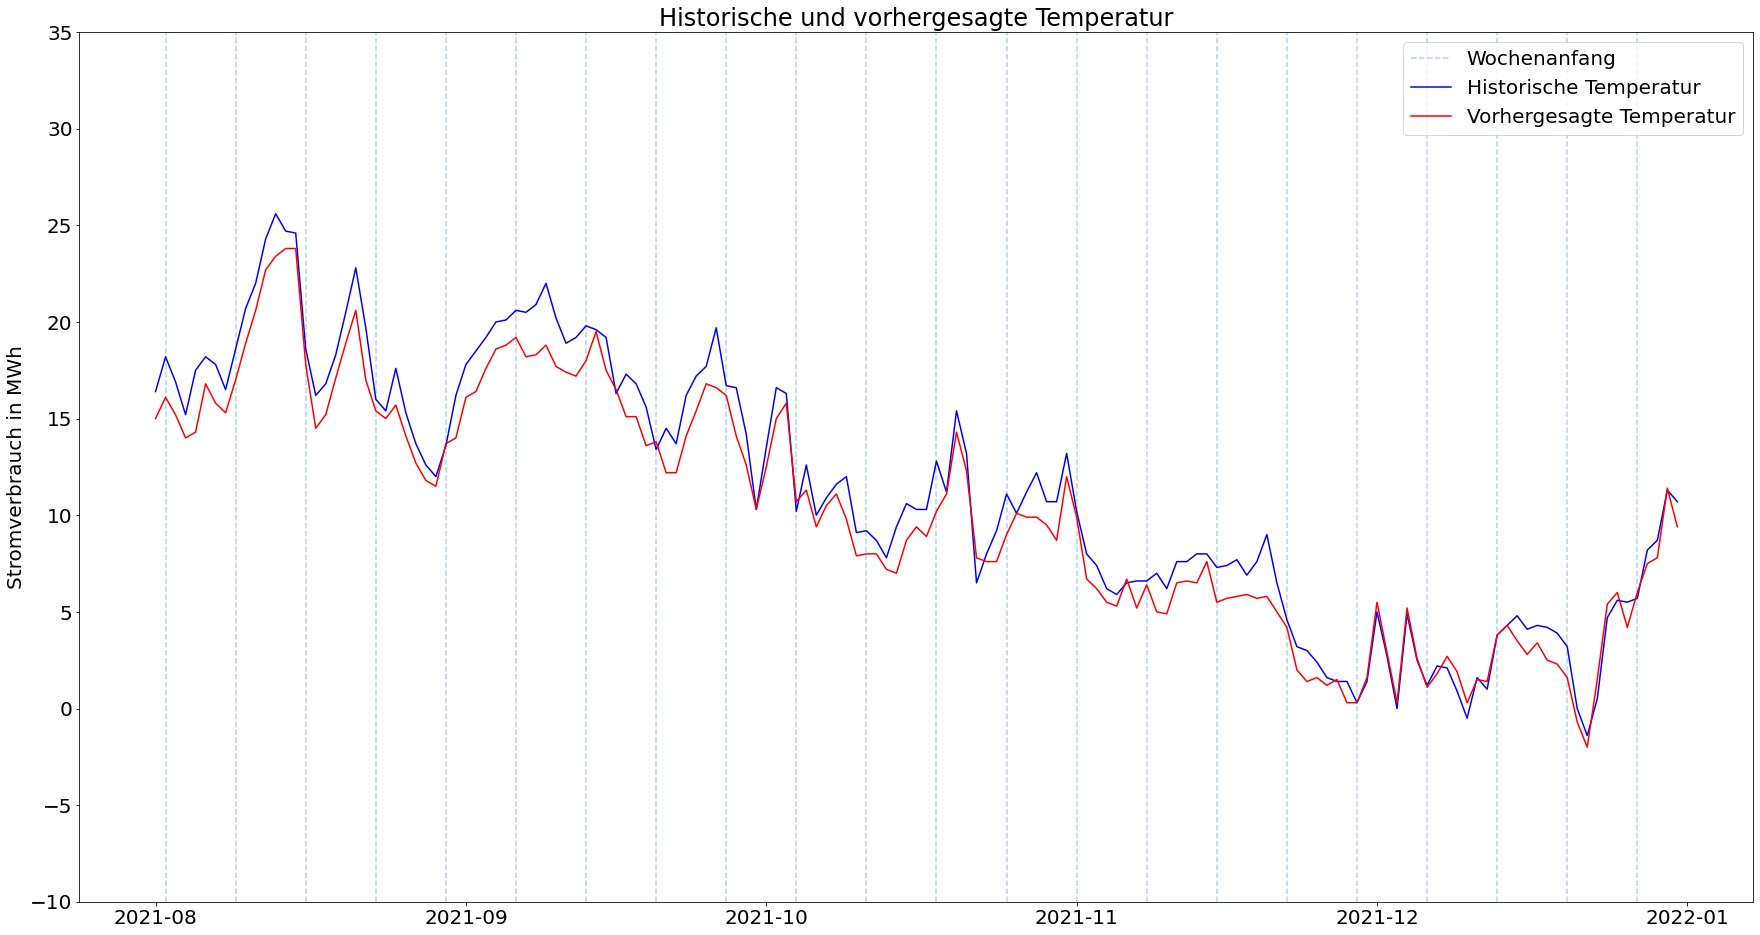

In [8]:
df_metrics = pd.DataFrame(index=["MAE", "MSE", "RMSE"])

df_metrics["Wettervorhersage"] = [
    round(metrics.mean_absolute_error(df_unscaled["temperatur"]["2021-08-01":], df_weatherforecast_unscaled["temperatur"]), 2),
    round(metrics.mean_squared_error(df_unscaled["temperatur"]["2021-08-01":], df_weatherforecast_unscaled["temperatur"]), 2),
    round(np.sqrt(metrics.mean_squared_error(df_unscaled["temperatur"]["2021-08-01":], df_weatherforecast_unscaled["temperatur"])), 2)
]

print(df_metrics)

for date in y_test_true[y_test_true.index.weekday == 0].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="lightblue", linestyle="--", label="Wochenanfang")

#plt.plot(y_test_true, color="blue", label="Wahr");
plt.plot(df_unscaled["temperatur"]["2021-08-01":], color="blue", label="Historische Temperatur");
plt.plot(df_weatherforecast_unscaled["temperatur"], color="red", label="Vorhergesagte Temperatur");
plt.title("Historische und vorhergesagte Temperatur")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(-10,35)
plt.legend(loc="upper right")

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper right")

plt.show()

## <font size="6">Vergleich</font>

<font size="5">
Die Modelle erstellen zunächst Vorhersagen mit den realistischen Daten.
</font>


In [9]:
arima_preds_scaled = arima_model.predict(start="2021-08-01", end="2021-12-31", dynamic=False)
arima_preds_weatherforecast = pd.DataFrame(data=scaler_target.inverse_transform(arima_preds_scaled.values.reshape(-1, 1)), columns=["arima"], index=pd.date_range('08/01/2021', periods=153, freq='D')).squeeze()

lstm_preds_scaled = lstm_model.predict(X_test_lstm)
lstm_preds_weatherforecast = pd.DataFrame(data=scaler_target.inverse_transform(lstm_preds_scaled.reshape(-1, 1)), columns=["lstm"], index=pd.date_range('08/01/2021', periods=153, freq='D')).squeeze()

baseline_preds = df_baseline = pd.read_csv("../1-Business Understanding/data_baseline.csv", index_col=0, parse_dates=True)["2021-08-01":]

arima_preds = pd.read_csv("arima_preds.csv", index_col=0, parse_dates=True)["2021-08-01":]
lstm_preds = pd.read_csv("lstm_preds.csv", index_col=0, parse_dates=True)["2021-08-01":]

### <font size="5">Statistiken</font><a class="anchor" id="5-02-statistiken"></a>

<font size="5">
Obwohl die Vorhersagen nur zu einem vergleichsweise kleinen Teil von der Temperatur abhängen, entstehen trotzdem beachtliche Abweichungen. ARIMA verschlechtert sich von 2,10% auf 2,22%, LSTM verschlechtert sich vom 1,94% auf 2,09%. Die Baseline erreicht im gleichen Zeitraum einen MAPE von 2,33%, das Erfolgskriterium läge in diesem Zeitraum also bei 2,10%. LSTM könnte das Erfolgskriterium trotzdem erfüllen, AIRMA hingegen nicht. Da hier allerdings nur ein sehr kleiner Zeitraum (mit den ungünstigen Feiertagen) betrachtet wird, ist dieser Test nur experimentell und nicht repräsentativ.
</font>


In [10]:
df_metrics = pd.DataFrame(index=["MAE", "MSE", "RMSE", "",  "MAPE"])

df_metrics["ARIMA"] = [
    round(metrics.mean_absolute_error(y_test_true, arima_preds_weatherforecast), 2),
    round(metrics.mean_squared_error(y_test_true, arima_preds_weatherforecast), 2),
    round(np.sqrt(metrics.mean_squared_error(y_test_true, arima_preds_weatherforecast)), 2),
    "",
    "" + str(round(metrics.mean_absolute_percentage_error(y_test_true, arima_preds_weatherforecast)*100, 2)) + " %"
]

df_metrics["LSTM"] = [
    round(metrics.mean_absolute_error(y_test_true, lstm_preds_weatherforecast), 2),
    round(metrics.mean_squared_error(y_test_true, lstm_preds_weatherforecast), 2),
    round(np.sqrt(metrics.mean_squared_error(y_test_true, lstm_preds_weatherforecast)), 2),
    "",
    "" + str(round(metrics.mean_absolute_percentage_error(y_test_true, lstm_preds_weatherforecast)*100, 2)) + " %"
]

df_metrics["Baseline"] = [
    round(metrics.mean_absolute_error(y_test_true, baseline_preds), 2),
    round(metrics.mean_squared_error(y_test_true, baseline_preds), 2),
    round(np.sqrt(metrics.mean_squared_error(y_test_true, baseline_preds)), 2),
    "",
    "" + str(round(metrics.mean_absolute_percentage_error(y_test_true, baseline_preds)*100, 2)) + " %"
]

print(df_metrics)

            ARIMA        LSTM     Baseline
MAE       3824.91     3499.63       4162.6
MSE   33513517.43  23321709.7  26739266.22
RMSE      5789.09     4829.26       5171.0
                                          
MAPE       2.22 %      2.09 %       2.33 %


### <font size="5">ARIMA</font><a class="anchor" id="5-02-arima"></a>

<font size="5">
Bei ARIMA kommt es vor Allem Ende Dezember zu sehr starken Abweichungen. 
</font>


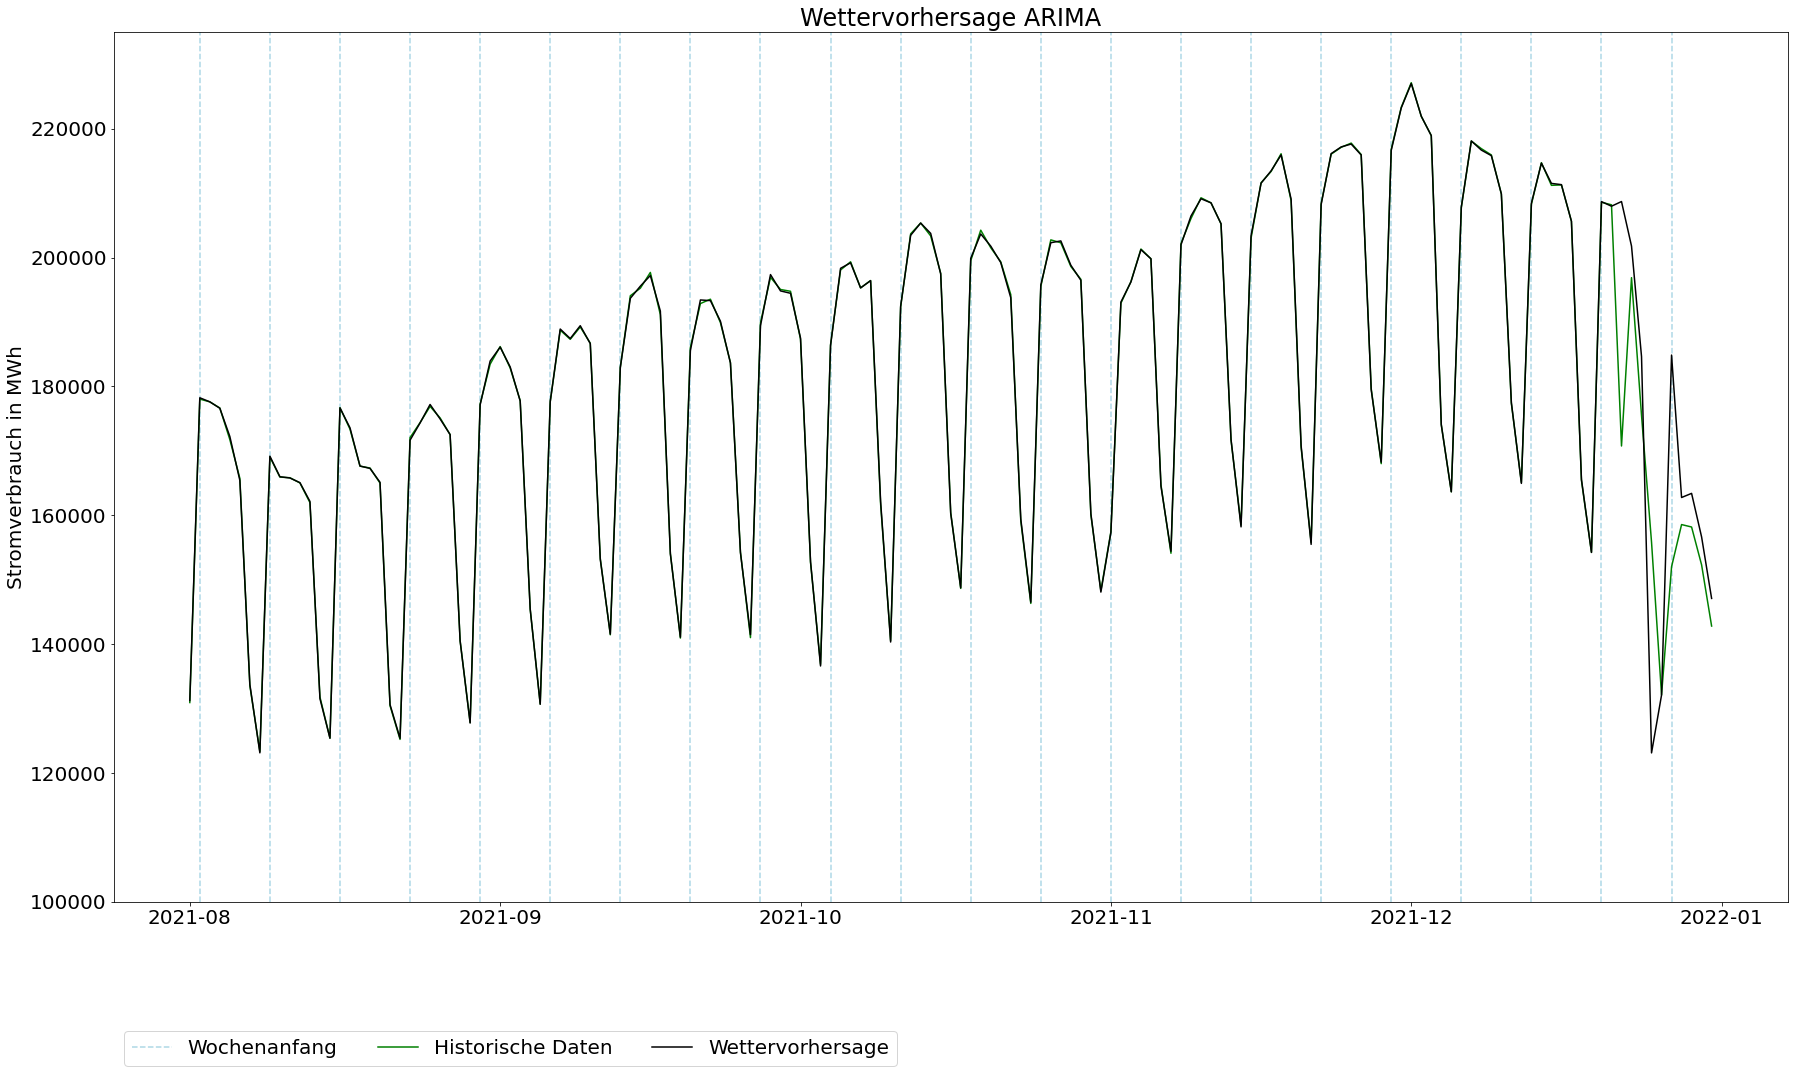

In [11]:
for date in y_test_true[y_test_true.index.weekday == 0].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="lightblue", linestyle="--", label="Wochenanfang")

#plt.plot(y_test_true, color="blue", label="Wahr");
plt.plot(arima_preds, color="green", label="Historische Daten");
plt.plot(arima_preds_weatherforecast, color="black", label="Wettervorhersage");
plt.title("Wettervorhersage ARIMA")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.legend(loc="upper right")

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=5)

plt.show()

### <font size="5">LSTM</font><a class="anchor" id="5-02-lstm"></a>

<font size="5">
Bei LSTM sind die Abweichungen einigermaßen über den ganzen Zeitraum verteilt.
</font>


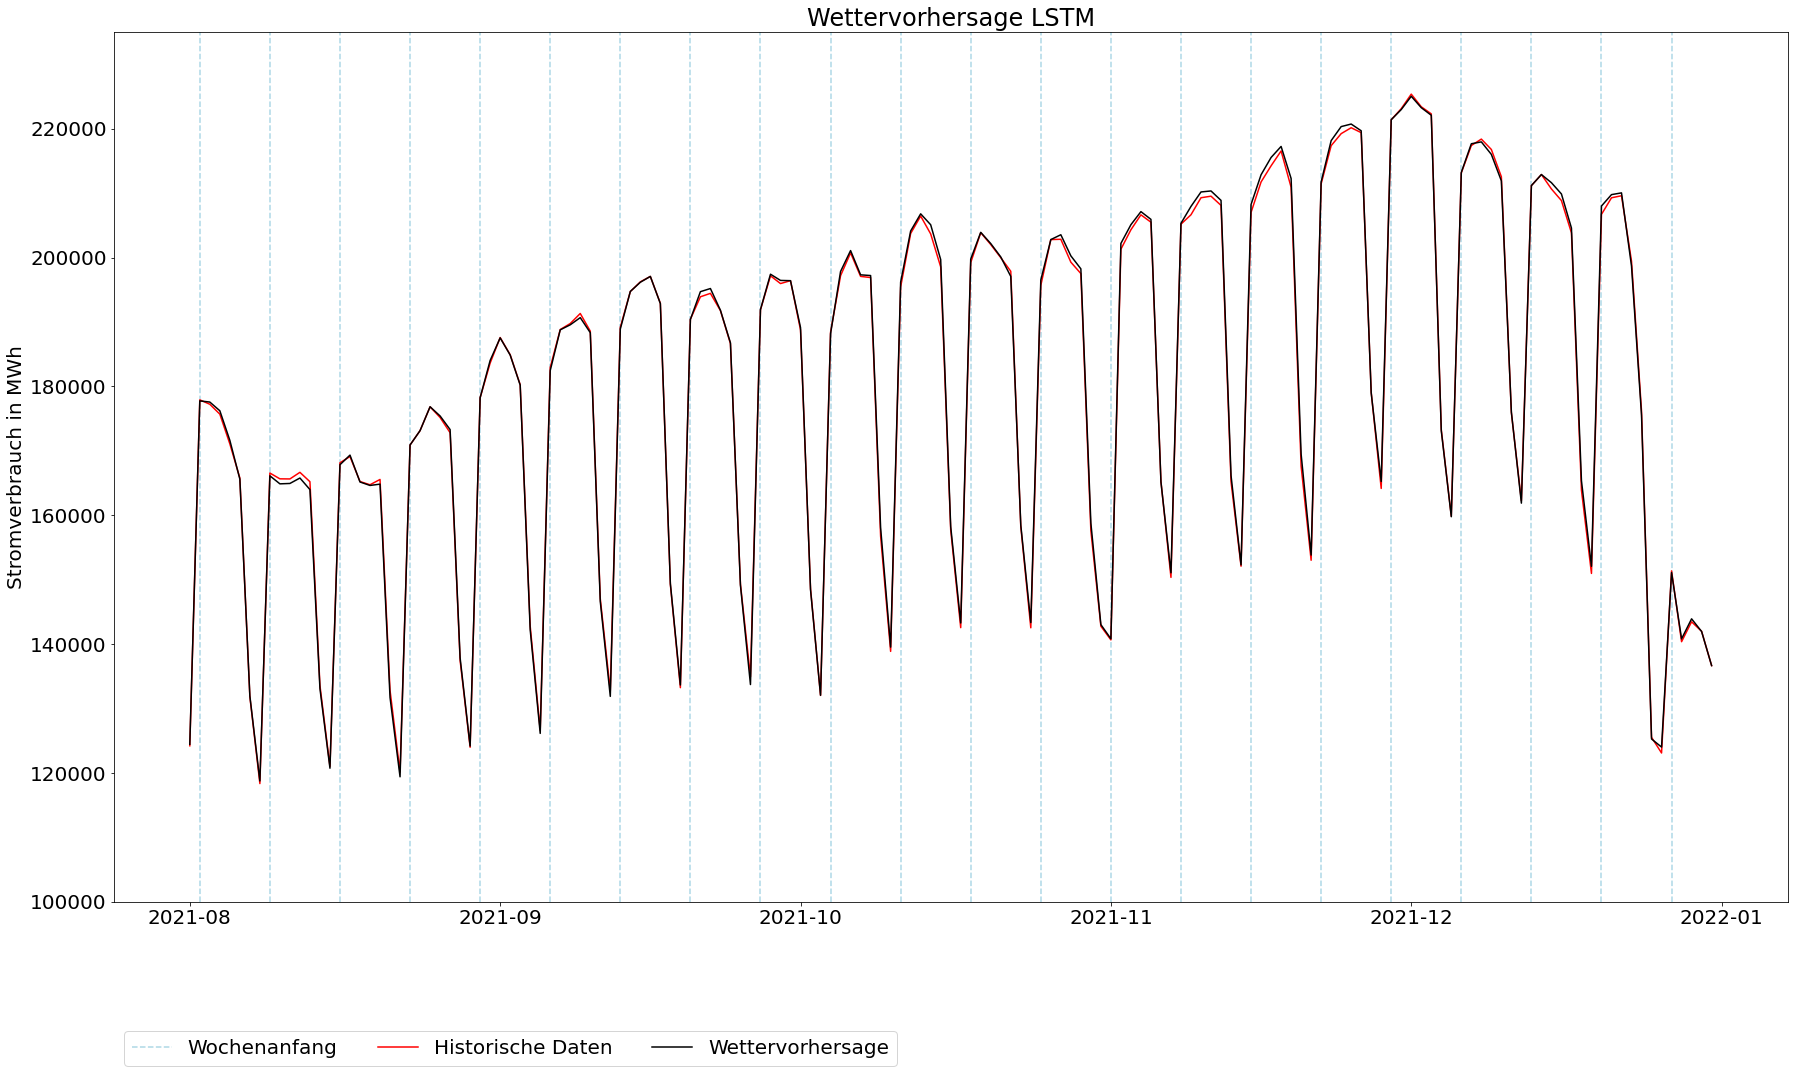

In [12]:
for date in y_test_true[y_test_true.index.weekday == 0].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="lightblue", linestyle="--", label="Wochenanfang")

#plt.plot(y_test_true, color="blue", label="Wahr");
plt.plot(lstm_preds, color="red", label="Historische Daten")
plt.plot(lstm_preds_weatherforecast, color="black", label="Wettervorhersage");
plt.title("Wettervorhersage LSTM")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.legend(loc="upper right")

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=5)

plt.show()

### <font size="5">ARIMA und LSTM</font><a class="anchor" id="5-02-arimalstm"></a>

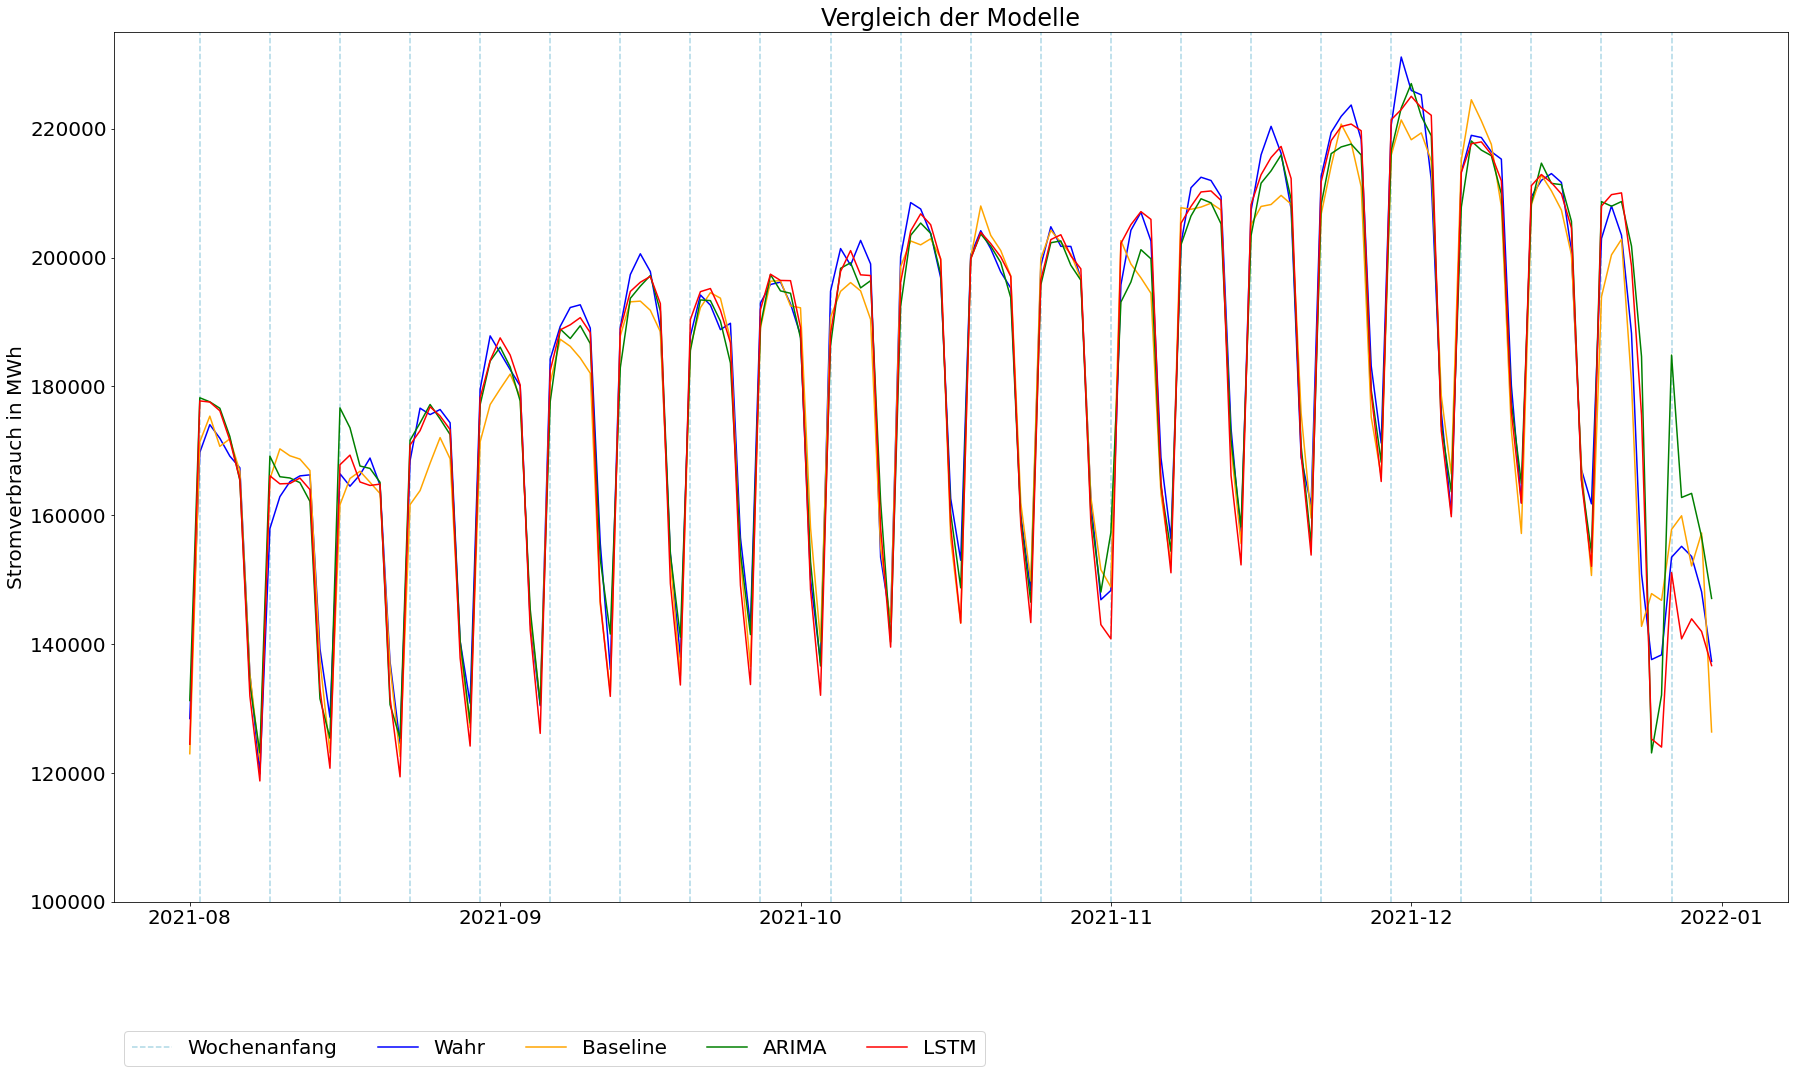

In [13]:
for date in y_test_true[y_test_true.index.weekday == 0].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="lightblue", linestyle="--", label="Wochenanfang")

plt.plot(y_test_true, color="blue", label="Wahr");
plt.plot(baseline_preds, color="orange", label="Baseline")
plt.plot(arima_preds_weatherforecast, color="green", label="ARIMA");
plt.plot(lstm_preds_weatherforecast, color="red", label="LSTM")
plt.title("Vergleich der Modelle")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.legend(loc="upper right")

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=5)

plt.show()